In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA

from lfads_torch.post_run.band_analysis import run_posterior_sampling

Matplotlib created a temporary cache directory at /tmp/matplotlib-bzoj7dv8 because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
dataset_name = 'chewie_10_07'
area = 'M1'
PATH = '/disk/scratch2/nkudryas/BAND-torch/datasets'

bin_size_ms = 10

In [4]:
models_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper/{dataset_name}_{area}"

fac_dim, co_dim = 4,2
bw = 0.1
n_neurons = 70
seed = 2
model_name = f'band_M1_{fac_dim}f_{co_dim}c_kl1_studentT_bs256_sample{seed}'
model_dest = f"{models_dest}/{model_name}"


In [5]:
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.utils import flatten

overrides={
        "datamodule": dataset_name,
        "model": dataset_name.replace('_M1', '').replace('_PMd',''),
        "model.fac_dim": fac_dim,
        "model.co_dim": co_dim,
        "model.encod_data_dim": n_neurons,
        "model.behavior_weight": bw,
        "seed": seed

    }
config_path="../../configs/single.yaml"
print(config_path)

# Compose the train config with properly formatted overrides
config_path = Path(config_path)
overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
with hydra.initialize(
    config_path=config_path.parent,
    job_name="get_weights",
    version_base="1.1",
):
    config = hydra.compose(config_name=config_path.name, overrides=overrides)

# Instantiate `LightningDataModule` and `LightningModule`
datamodule = instantiate(config.datamodule, _convert_="all")
model = instantiate(config.model)

ckpt_path = f'{model_dest}/lightning_checkpoints/last.ckpt'
model.load_state_dict(torch.load(ckpt_path)["state_dict"])

../../configs/single.yaml


<All keys matched successfully>

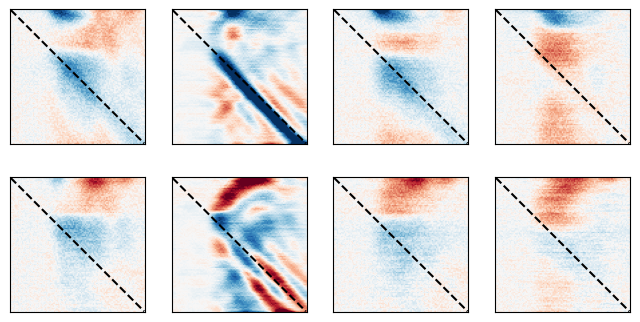

In [11]:
seq_len = config.model.recon_seq_len
in_features = config.model.behavior_readout.modules[0].in_features
out_features = config.model.behavior_readout.modules[0].out_features
beh_W = model.behavior_readout[0].layers[1].weight.T

assert beh_W.shape == (in_features*seq_len, out_features*seq_len)

beh_W = beh_W.reshape((seq_len, in_features, seq_len, out_features))

r = torch.std(beh_W)*4
fig, ax = plt.subplots(out_features, in_features, figsize=(2*in_features, 2*out_features))
for j in range(in_features):
    for i in range(out_features):
        ax[i,j].imshow(beh_W[:,j,:,i].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].plot([0,seq_len-1], [0, seq_len-1], 'k--')

In [16]:
# load the dataset
assert len(config.datamodule.data_paths) == 1, 'Assumed a single dataset, got more'
dataset_filename = config.datamodule.data_paths[0] 

with h5py.File(dataset_filename, 'r') as f:
    train_data = f['train_recon_data'][:]
    valid_data = f['valid_recon_data'][:]
    train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
    valid_epoch = f["valid_epoch"][:]
    true_train_beh = f['train_vel'][:]
    true_valid_beh = f['valid_vel'][:]
    true_target_direction = f['valid_target_direction'][:]

true_pos = np.cumsum(true_valid_beh,axis=1) 

# load model components
data_path = model_dest + '/lfads_output_sess0.h5'
with h5py.File(data_path) as f:
    # print(f.keys())
    # Merge train and valid data for factors and rates
    train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
    factors = f["valid_factors"][:]
    rates = f["valid_output_params"][:] / bin_size_ms
    train_behavior = f["train_output_behavior_params"][:]
    behavior = f["valid_output_behavior_params"][:]
    controls = f['valid_gen_inputs'][:]
    ic = f['valid_gen_init'][:]

    train_factors = f["train_factors"][:]
    train_controls = f['train_gen_inputs'][:]
    train_ic = f['train_gen_init'][:]

# load ablated model components
data_path = model_dest + '/lfads_ablated_output_sess0.h5'
with h5py.File(data_path) as f:
    noci_factors = f["valid_factors"][:]
    noci_behavior = f["valid_output_behavior_params"][:]

    noci_rates = f["valid_output_params"][:] / bin_size_ms
    # noci_controls = f['valid_gen_inputs'][:]

In [15]:
rates.shape

(116, 101, 70)

# Plot firing rate difference with/without controls

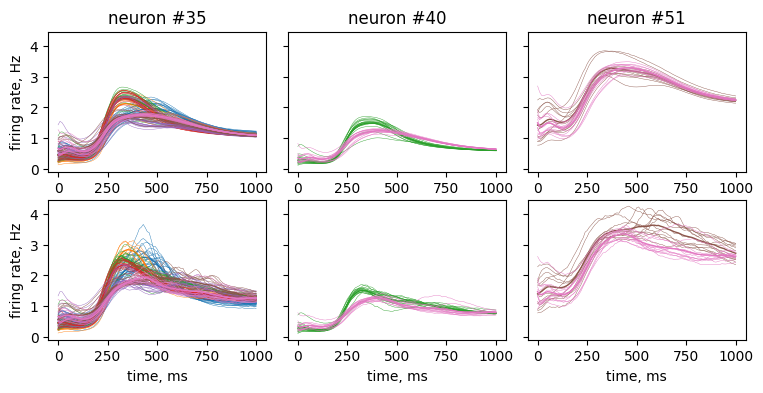

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(9, 4), sharey=True)

for k, (n, sub) in enumerate(zip([35, 40, 51], [[0,1, 2,3,4,5,6], [2, 6], [5, 6]])):
    unique_dirs = np.unique(true_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i,frs in enumerate([noci_rates, rates]):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = true_target_direction == d
                axes[i, k].plot(
                    time,
                    100 * frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[i, k].plot(
                    time, 100 * frs[mask][..., n].T, linewidth=0.3, c=f"C{j}"
                )

                if i == 0:
                    axes[0, k].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[i, k].set_ylabel("firing rate, Hz")
                axes[i, k].set_xlabel("time, ms")
                # axes[i, k].set_ylim([0, 65])

# axes[0, 0].set_title("LFADS")
# axes[0, 1].set_title("Ctrl-TNDM")

# plt.legend(loc=(1.5, 0))
plt.subplots_adjust(wspace=0.1)
plt.savefig(f"fig3c.svg")

In [7]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

# widget to scroll through trials
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

@widgets.interact
def plot_trial(trial_id=widgets.IntSlider(min=0, max=valid_data.shape[0]-1, step=1, value=0)):

    fig = plt.figure(figsize=(10, 4))

    # blank = fig.add_axes([0,0,1,1], frameon=True)

    axis_IC = fig.add_axes([0.05, 0.6, 0.1, 0.25])

    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    # print(train_ic.shape,ic_pca.shape)

    axis_IC.set_title('Initial Conditions')
    axis_IC.scatter(*ic_pca.T,c=cm.rainbow(get_target_ids(true_target_direction)/8),s=2)
    axis_IC.scatter(*ic_pca[trial_id],c='k',
                    s=50,marker='*')
    axis_IC.scatter(*ic_pca[trial_id],c=cm.rainbow(get_target_ids(true_target_direction)/8)[trial_id],
                    s=20,marker='*')
    axis_IC.set_xlabel('PC1')
    axis_IC.set_ylabel('PC2')
    axis_IC.set_xticks([])
    axis_IC.set_yticks([])

    time = np.arange(controls.shape[1])*bin_size_ms
    axis_controls = fig.add_axes([0.05, 0.15, 0.25, 0.25])
    axis_controls.set_title('Controls')
    axis_controls.plot(time,controls[trial_id])
    axis_controls.set_xlabel('Time (ms)')
    axis_controls.set_ylabel('Control input')

    axis_factors = fig.add_axes([0.38, 0.6, 0.25, 0.25])
    axis_factors.set_title('Autonomous Factors')
    axis_factors.plot(time,(noci_factors[trial_id] - noci_factors[trial_id].mean(0))[:])
    axis_factors.set_xlabel('Time (ms)')
    axis_factors.set_ylabel('Factor')

    axis_noci_factors = fig.add_axes([0.38, 0.15, 0.25, 0.25])
    axis_noci_factors.set_title('Controlled Factors')
    axis_noci_factors.plot(time,(factors[trial_id] - factors[trial_id].mean(0))[:])
    axis_noci_factors.set_xlabel('Time (ms)')
    axis_noci_factors.set_ylabel('Factor')

    # draw an arrow from IC to autonomous factors

    axis_noci_behavior = fig.add_axes([0.71, 0.6, 0.25, 0.25])
    axis_behavior = fig.add_axes([0.71, 0.15, 0.25, 0.25])
    axis_noci_behavior.set_title('Behavior prediction from Autonomous')
    axis_behavior.set_title('Behavior prediction from Controlled')
    axis_noci_behavior.set_xlabel('Time (ms)')
    axis_noci_behavior.set_ylabel('Behavior')
    axis_behavior.set_xlabel('Time (ms)')
    axis_behavior.set_ylabel('Behavior')
    for i in [0,1]:
        axis_noci_behavior.plot(noci_behavior[trial_id][:,i],c=f'C{i}')
        axis_noci_behavior.plot(true_valid_beh[trial_id][:,i],linestyle=':',c=f'C{i}')
        axis_behavior.plot(behavior[trial_id][:,i],c=f'C{i}')
        axis_behavior.plot(true_valid_beh[trial_id][:,i],linestyle=':',c=f'C{i}')
    axis_noci_behavior.legend(['Predicted','True'])
    axis_behavior.legend(['Predicted','True'])

interactive(children=(IntSlider(value=0, description='trial_id', max=115), Output()), _dom_classes=('widget-in…